# Reinforcement Q-learning simple NN as function approximation

- portfolio grid of size 10 (0 to 1)
- 1 hidden neural layers 
- Improved by Dropout 

In [1]:
# Initialization
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('data_ext.csv') #Three stocks (R,X_s,X_b) Without predictors

# Initialization of the Tensorflow placeholders and the network

In [4]:
#Initialize Neural Network and set-up the placeholders
tf.reset_default_graph()
NN_input = tf.placeholder(shape=[1,6],dtype=tf.float32)
NN_weights = tf.Variable(tf.random_uniform([6,10],0,0.01))
b = tf.Variable(np.zeros((1,10)), dtype=tf.float32)
Q_FA = tf.tanh(tf.matmul(NN_input,NN_weights) + b)     ## very important 
Q_dropout = tf.nn.dropout(Q_FA,0.2)
A_Max = tf.argmax(Q_dropout,1)

# Calculate loss for the NN from the Q values
Q_Next = tf.placeholder(shape=[1,10],dtype=tf.float32)
# loss = tf.reduce_sum(tf.square(Q_Next - Q_FA))
loss = tf.reduce_sum(tf.square(Q_Next - Q_dropout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

#Define Action Matrix (Now discrete case) 
A = np.linspace(0,1,10) # portfolio weights of stocks (1-weight) is the weight in the bonds

# Training of the NN function approximation

549
Writing away results
550
Writing away results
551
Writing away results
552
Writing away results
553
Writing away results
554
Writing away results
555
Writing away results
556
Writing away results
557
Writing away results
558
Writing away results
559
Writing away results
560
Writing away results
561
Writing away results
562
Writing away results
563
Writing away results
564
Writing away results
565
Writing away results
566
Writing away results
567
Writing away results
568
Writing away results
569
Writing away results
570
Writing away results
571
Writing away results
572
Writing away results
573
Writing away results
574
Writing away results
575
Writing away results
576
Writing away results
577
Writing away results
578
Writing away results
579
Writing away results
580
Writing away results
581
Writing away results
582
Writing away results
583
Writing away results
584
Writing away results
585
Writing away results
586
Writing away results
587
Writing away results
588
Writing away results


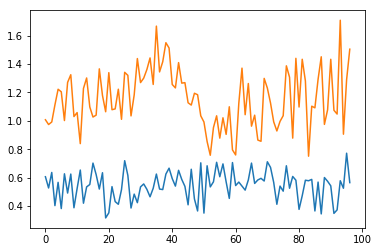

In [5]:
# initialize
init = tf.global_variables_initializer()
gamma = 1 
epsilon = 0.1
jList = []
TWlistTrain = []
TWlist = []
Index = []
MWeights = []
# data parsing
dates = data['Date']
mdata = data[['r','xs','xb','snom','spe','sspr']]
mdata.index = pd.DatetimeIndex(dates)
n = 707
periods = 60
epochs = 10     # preferred to have a low amount of epochs because otherwise the the same data is used multiple times (usually not the case in stock returns)

with tf.Session() as sess:
    for i in range(549,int(n-periods-1)):
        OptimalWeights = np.zeros(periods-1)
        currentK = 0
        sess.run(init) # initialize the Neural Network again
        print(i)
        end = 0
        
        while currentK < periods - 1:
            #Initilization
            NN_data = mdata[0:i+currentK]  # Expanding window
            currentEpoch = 0
            
            indexes = np.asarray(range(len(NN_data)))
            end = len(NN_data)
            np.random.shuffle(indexes)
            
            while currentEpoch < epochs:
                #Training of the Q-Network for the data available (with Neural Nets) 
                for j in indexes:
                    s = NN_data.iloc[j,:].values.reshape(1,6)
                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    a_int,allQ = sess.run([A_Max,Q_FA],feed_dict={NN_input:s})
                    a = A[a_int-1]  # -1 because the output neurons are labeled 1 till 101 and it will be an index
                    if np.random.rand(1) < epsilon:
                        a = random.choice(A)

                    #Get new state and reward from environment
                    s1 = mdata.iloc[j+1,:].values.reshape(1,6)
                    r = (a*s1[0][0] + (1-a)*s1[0][1]) #reward: this is now the wealth gained from this step, but could be other rewards like utility
                    Q = sess.run(Q_FA,feed_dict={NN_input:s1})

                    #Obtain maxQ' and set our target value for chosen action.
                    Q1 = np.max(Q)
                    targetQ = allQ
                    targetQ[0,a_int] = r + gamma*Q1

                    #Train the neural network using target and predicted Q values
                    _,W1 = sess.run([updateModel,NN_input],feed_dict={NN_input:s,Q_Next:targetQ})
                    s =  mdata.iloc[j+1,:].values.reshape(1,6)
                    if i  > 100:
                        # decrease amount of random actions over time in order to improve exploitation rather than exploration
                        # only increase exploitation when a good action has been found (otherwise one exploits a bad solution)
                        epsilon = 1./((i/50) + 10)
                currentEpoch += 1
        
            # After training now calculate the optimal weights for the K=60 periods to come
            s = mdata.iloc[i+periods,:].values.reshape(1,6)
            a_int,allQ = sess.run([A_Max,Q_FA],feed_dict={NN_input:s})
            aOpt = A[a_int-1]
            OptimalWeights[currentK] = aOpt
            currentK += 1
        
        # For insight purposes
        MWeights.append(np.mean(OptimalWeights))
        TWlist.append(np.exp(sum(OptimalWeights*mdata[i+1:i+currentK+1]['xs'] + (1-OptimalWeights)*mdata[i+1:i+currentK+1]['xb'])))
        Index.append(i)
        
        print('Writing away results')
        df = pd.DataFrame({'index date':Index,'TW':TWlist, 'Mean Weights Xs':MWeights})
        df.to_excel('Results_NN_g10_ExtraData_e10_3.xlsx', sheet_name='sheet1', index=False)
plt.plot(MWeights)
plt.plot(TWlist)
        